These are functions for setwise sums in Z^n.
Most objects are implemented as numpy arrays, i.e., sets of points are input as matrices whose rows are the points.

In [2]:
import numpy as np
from time import time
import itertools as it
import scipy.spatial as sp
#from scipy.spatial import ConvexHull as hull
#from scipy.spatial import convex_hull_plot_2d as ch_plot
import matplotlib.pyplot as plt

In [4]:
#Functions for setwise sums, etc

def setsum(X,Y): #returns X+Y={x+y: (x,y) in (X,Y)}
    return np.array([x+y for x in X for y in Y])

def msum(*listofsets): #n-ary version of setsum
    S = listofsets[0]
    if len(listofsets) == 1:
        return S
    else:
        for i in range(1,len(listofsets)):
            S = setsum(S,listofsets[i])
        return S

def translate(X,c): #translates X by c
    return np.array([x+c for x in X])

def dilate(X,k): #dilates X by k
    return np.array([k*x for x in X])

In [5]:
#Functions for convex hull

'''
cv_hull uses the scipy.spatial ConvexHull function to assemble the hull.  
It has built-in methods for finding vertices and other facets of higher dimensions.
'''

def cv_hull(X): #returns the convex hull (not good for iterating, but for detecting facets) 
    return sp.ConvexHull(X)

def coord_bounds(X,i): #returns a tuple of (lowest vals in each coord, highest vals+1 in each coord)
    return (min(X[:,i]),max(X[:,i])+1)

def prelattice(X): #fills in the points of the smallest box in which X can be inscribed
    ranges = []
    for i in range(np.shape(X)[1]):
        ranges.append(range(*coord_bounds(X,i)))
    return np.array([p for p in it.product(*ranges)])

def in_hull(p, X): #for a point p, determines whether p is in the convex hull of X
    Xp = np.array([x for x in X]+[p])
    HX = cv_hull(X)
    HXp = cv_hull(Xp)
    if list(HX.vertices) == list(HXp.vertices):
        return True
    else:
        return False

def interior(X): #returns all lattice points in the interior (and boundary) of X
    lat = []
    H = cv_hull(X)
    for x in prelattice(X):
        if in_hull(x,X):
            lat.append(x)
    return np.array(lat)
            

In [6]:
#Functions for plotting; good for quick, 2D visuals

def plot(X):
    plt.plot(X[:,0],X[:,1],'o')

def plot_hull(X):
    for s in cv_hull(X).simplices:
        plt.plot(X[s,0],X[s,1],'k--')

In [7]:
#Functions for intersection and 'minkowski subtraction'

def point_in(x,Y): #determines if a vector x lies in Y
    return list(x) in [list(y) for y in Y]

def common(X,Y): #this intersects the arrays X and Y, finding all vectors belonging to both
    C = []
    for x in X:
        if point_in(x,Y):
            C.append(x)
    return np.array(C)

def cofactor(X,A): #returns the maximum possible B such that A + B = X 
    C = X-A[0]
    for a in A[1:]:
        C = common(X-a,C)
    return C

In [8]:
#Functions for special polytopes

def reduce(S): #[(3,0,0),(2,0,1)] ---> [(1,0,0),(0,0,1)] # removes extra weight in each coordinate
    return S - np.array([np.amin(S,0)])


def faces_inds(X): #returns a dict with dict[face_plane_eqn]=[indices of vertices of face]
    HX = cv_hull(X)
    E = np.unique(HX.equations,axis = 0)    #equations of planes through faces
    indices = [[] for e in E]
    N = np.array([e[0:E.shape[1]-1] for e in E])       #normal vectors of planes
    d = np.array([[e[E.shape[1]-1]] for e in E])       #offsets of planes
    for s in HX.simplices:
        pts = X[s]                          ro#3 points of a simplicial facet
        R = np.matmul(N,pts.T)+d            #N*(pts^T)-d; tests membership of pts in each plane
        plane_ind = np.where((R==0).all(axis=1))
        indices[int(plane_ind[0])] += ([a for a in s])
    return [list(set(indices[i])) for i in range(len(indices))]

def faces(X):
    return [X[i] for i in faces_inds(X)]
    

def comp(X):
    return -X + np.amax(X,0)
#Need definition for edge polygons

Here are some examples of some of the above functions being used:

In [20]:
X = np.random.randint(1,10,[5,2]) #choosing random point sets X and Y, with 5 and 4 points, respectively
Y = np.random.randint(1,10,[4,2])

In [21]:
Z = setsum(X,Y) #this is the minkowski sum of our X and Y

In [22]:
###################
# START DEMO HERE #
###################

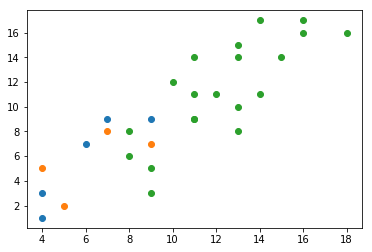

In [23]:
#for visualization purposes, let's see a plot of our X, Y, and X+Y
plot(X)
plot(Y)
plot(Z)

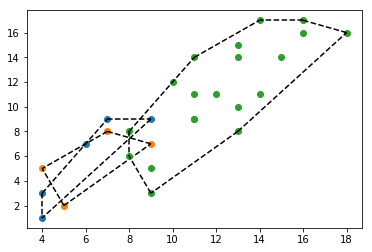

In [24]:
#seeing the actual convex hulls involved cleans up the picture (somewhat)
plot(X)
plot_hull(X)
plot(Y)
plot_hull(Y)
plot(Z)
plot_hull(Z)

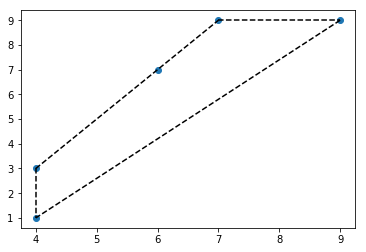

In [25]:
#Let's look at just the polygon X a little more closely
plot(X)
plot_hull(X)

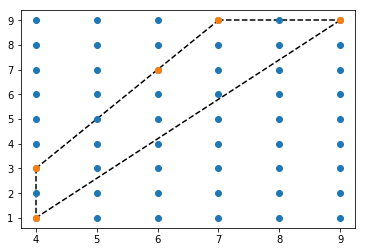

In [26]:
#we can see the vertices, maybe some interior points, and maybe non-vertices along the edges
#but we can fill in the whole picture


plot_hull(X)

#first fill in the smallest box which contains all points of X

plot(prelattice(X))
plot(X)

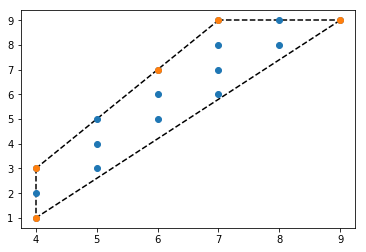

In [27]:
plot_hull(X)

#then we select the points which actually appear inside (or on the boundary) of the hull of X

plot(interior(X))
plot(X)

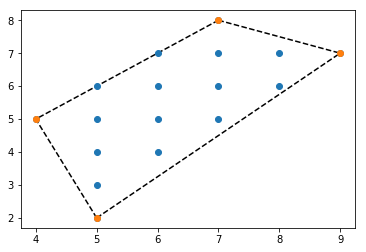

In [28]:
# We can do the same for Y:

plot_hull(Y)
plot(interior(Y))
plot(Y)

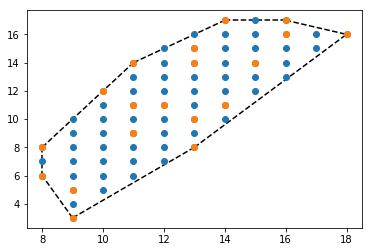

In [29]:
# And for Z = X + Y

plot_hull(Z)
plot(interior(Z))
plot(Z)

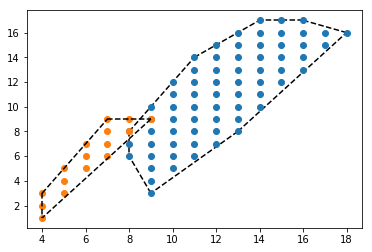

In [31]:
#What about disassembling these polygons?  We can try to subtract Y from Z:

Xi = interior(X)
Yi = interior(Y)
Zi = interior(Z)

plot_hull(Z)
plot(Zi)
plot(cofactor(Zi,Yi))
plot_hull(X)

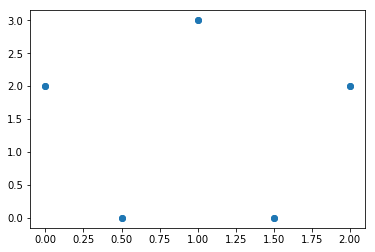

In [33]:
#Test example for face-finding functions

B = np.array([
    [.5,0,0],[1.5,0,0],[2,2,0],[1,3,0],[0,2,0],
    [.5,0,1],[1.5,0,1],[2,2,1],[1,3,1],[0,2,1]])
plot(B);

In [34]:
HB = cv_hull(B)

In [35]:
for f in faces(B):
    print(f)

[[0.5 0.  0. ]
 [0.  2.  1. ]
 [0.  2.  0. ]
 [0.5 0.  1. ]]
[[1. 3. 1.]
 [0. 2. 1.]
 [1. 3. 0.]
 [0. 2. 0.]]
[[0.5 0.  0. ]
 [1.5 0.  0. ]
 [0.5 0.  1. ]
 [1.5 0.  1. ]]
[[0.5 0.  0. ]
 [1.5 0.  0. ]
 [2.  2.  0. ]
 [1.  3.  0. ]
 [0.  2.  0. ]]
[[0.5 0.  1. ]
 [1.5 0.  1. ]
 [2.  2.  1. ]
 [1.  3.  1. ]
 [0.  2.  1. ]]
[[1. 3. 1.]
 [2. 2. 0.]
 [1. 3. 0.]
 [2. 2. 1.]]
[[1.5 0.  0. ]
 [2.  2.  0. ]
 [1.5 0.  1. ]
 [2.  2.  1. ]]


In [ ]:
f = faces(B)[0]
f[1]

In [ ]:
E = np.unique(HB.equations,axis=0)
N = np.array([e[0:3] for e in E])
d = np.array([[e[3]] for e in E])
for s in HB.simplices:
    t = B[s]
    R = np.matmul(N,t.T)+d
    ind = np.where((R==0).all(axis=1))
    print(ind)

In [ ]:
s = HB.simplices[4]
s
t = B[s]

In [ ]:
R = np.matmul(N,t.T)+d
R

In [ ]:
t

In [ ]:
E